# Cheatsheet @Alberto Eusebio

In [ ]:
# !pip install seaborn
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install sklearn
# !pip install scipy

In [2]:
# plotting
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import jax.numpy as jnp
import jax

# scientific computing
import numpy as np
import pandas as pd

## Importing Image
import from file and conversion to grayscale

(1333, 2000)

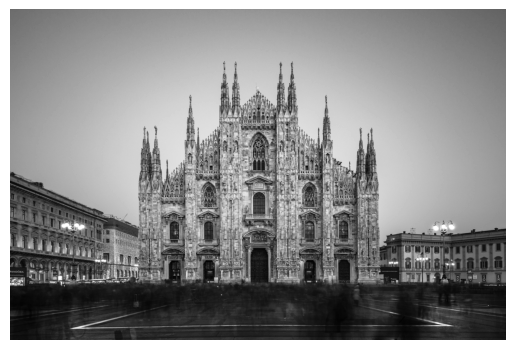

In [5]:
image_path = '/Users/hp/Downloads/duomo.jpg'
img = np.array(imread(image_path), np.float64)
A = np.mean(img, axis = 2) # averages the values on the third axis (RGB) to get a 2D array
plt.imshow(A, cmap = 'gray')
plt.axis('off')
A.shape # (height, width)

## Plotting the trend of singular values

- the singular values $\sigma_k$
- the cumulate fraction of singular values: $\frac{\sum_{i=1}^{k} \sigma_i}{\sum_{i=1}^{q} \sigma_i}$
- the fraction of the "explained variance": $\frac{\sum_{i=1}^{k} \sigma_i^2}{\sum_{i=1}^{q} \sigma_i^2}$

Text(0.5, 1.0, 'Explained variance')

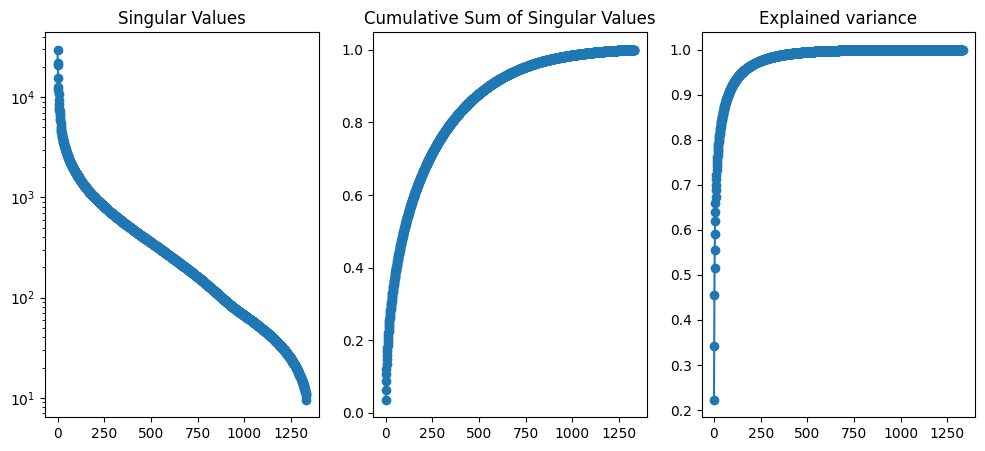

In [11]:
A_mean = np.mean(A, axis = 1) # average the columns into a 1D array

U, s, VT = np.linalg.svd(A-A_mean[:, None], full_matrices = False) #computing svd

# plotting the singular values

fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes = axes.flatten()

axes[0].semilogy(s, 'o-')
axes[0].set_title('Singular Values')

axes[1].plot(np.cumsum(s)/np.sum(s),'o-')
axes[1].set_title('Cumulative Sum of Singular Values')

axes[2].plot(np.cumsum(s**2)/np.sum(s**2), 'o-')
axes[2].set_title('Explained variance')

## PCA

Principal component analysis consist in finding the principal components that mostly explain the dataset.
Usually it boils down to a set of 5-10 singular values $\sigma_i$ that explain 90% of the varaince

Before doing so, the data should be at least centered(subtracting the mean) and possibly normalized.

The columns of matrix U are the principal axes.

**N.B. Before computing SVD, make sure that the class you want to distinguish is among columns and the features you wnat to use to find it are the rows (contentration_ions X patiences)**

$\Phi = U^T \cdot (A - A_{mean}) = (A - A_{mean})^T \cdot U$ When Feautures overcome rows

In [14]:
A = pd.read_csv('data.csv')
labels = pd.read_csv('data_labels.csv')

U, s, VT = np.linalg.svd(A-A_mean[:, None], full_matrices=False)
Phi = (A - A_mean[:, None]).T @ U

print(Phi.shape)

fig, axes = plt.subplots(1, 1, figsize = (12, 5))

axes.scatter(Phi[labels == 'type1', 0], Phi[labels == 'type1', 1], label = 'type1', color='r', marker='o')
axes.scatter(Phi[labels == 'type2', 0], Phi[labels == 'type2', 1], label = 'type2', color='b', marker='o')

(2000, 1333)


## Randomized SVD
Useful for lower rank approximation of matrix X

In [15]:
def randomized_SVD(A, k):
  n, m = A.shape[0], A.shape[1]
  P = np.random.randn(m, k) # generate a random matrix of size (m,k)
  #print(P.shape)
  #print(np.mean(P, axis=(0, 1)), np.std(P, axis=(0, 1)))
  Z = A @ P
  #print(Z.shape)
  Q, R = np.linalg.qr(Z)
  #print(Q.shape, R.shape)
  Y = Q.T @ A
  #print(Y.shape)
  U_Y, s, VT = np.linalg.svd(Y, full_matrices = False)
  U = Q @ U_Y
  #print(U.shape, s.shape, VT.shape)
  return U, s, VT


def randomized_SVD_oversample(A, k, ov):
  # Oversampling is a technique used in randomized SVD to improve the accuracy of the approximation (more information in intermediate steps)
  # by generating a random matrix of size (m, k*ov) instead of (m, k)
  # N.B. the rank of the oversampled matrix is ov*K, but the rank of the approximation is still K, so must be returned only the first K columns of U, s, VT
  n, m = A.shape[0], A.shape[1]
  P = np.random.randn(m, int(ov * k)) # generate a random matrix of size (m,k)
  #print(P.shape)
  #print(np.mean(P, axis=(0, 1)), np.std(P, axis=(0, 1)))
  Z = A @ P
  #print(Z.shape)
  Q, R = np.linalg.qr(Z)
  #print(Q.shape, R.shape)
  Y = Q.T @ A
  #print(Y.shape)
  U_tilde, s, VT = np.linalg.svd(Y, full_matrices = False)
  U = Q @ U_tilde
  #print(U.shape, s.shape, VT.shape)
  return U[:, k], s[:k], VT[:k, :]

## Compressing an image

The idea below matrix compression is to compute a lower rank approximation of the matrix.

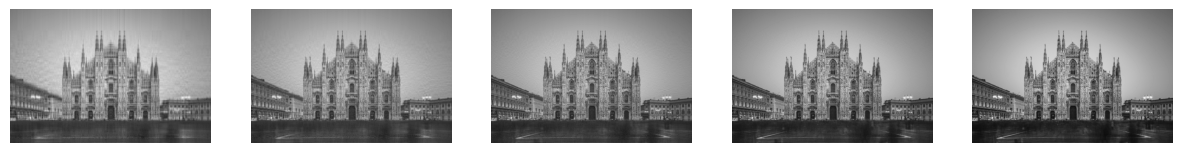

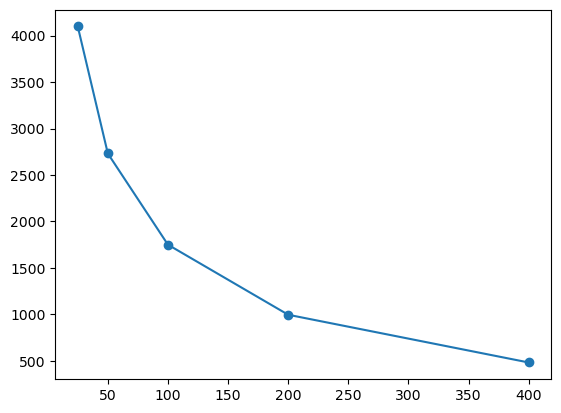

In [6]:
# To compress the image, we can use the first k singular values and the corresponding left and right singular vectors to reconstruct the image.
# Using the SVD truncation theorem, we know that the best rank-k approximation of A is given by the first k singular values and the corresponding left and right singular vectors.
ranks = [25, 50, 100, 200, 400]

U, s, VT = np.linalg.svd(A, full_matrices = False)

fig, axes = plt.subplots(1, 5, figsize = (15, 5))
axes = axes.flatten()

error_kistory = []
for i, k in enumerate(ranks):
    A_k = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    axes[i].imshow(A_k, cmap = 'gray') # plot the compressed image
    axes[i].axis('off')

    error_kistory.append(np.linalg.norm(A - A_k, ord = 2)) # compute the error

plt.figure()
plt.plot(ranks, error_kistory, 'o-')

## Timing Execution

In [ ]:
%timeit randomized_svd(A, 200)
%timeit np.linalg.svd(A, full_matrices = False)
%timeit randomized_svd(A, 200)

## Plotting a 3d surface

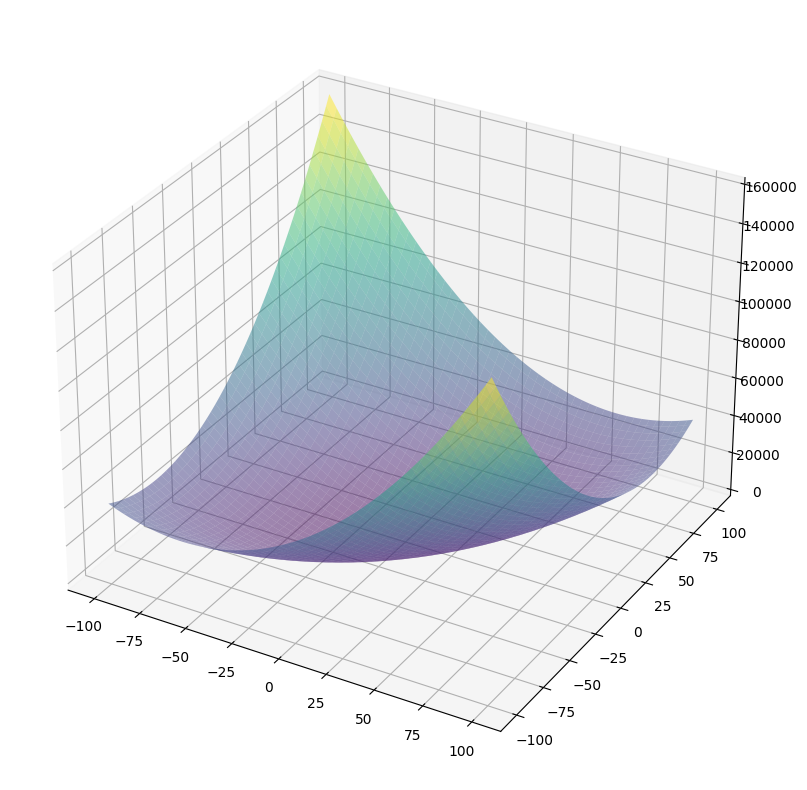

In [3]:
f = lambda x, y: 5*x**2 - 6 *x*y +5 * y**2 + 4* x + 4 * y
x = np.linspace(-100, 100, 200)
y = np.linspace(-100, 100, 200)

#print(*np.meshgrid(x, y)[1])
#print(f(*np.meshgrid(x, y)))

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(np.meshgrid(x, y)[0], np.meshgrid(x, y)[1], f(*np.meshgrid(x, y)), cmap = 'viridis', alpha = 0.5) # the sta

## Convolutions and FFT

### Toeplitz and Circulant matrices

In [36]:
from scipy.linalg import toeplitz, circulant

T = toeplitz([1,3,4], [1,2,5,6]) # first column, first row
C = circulant([1, 5, 3]) # row that will circulate

We consider the signal 

$f(t) = \sin(h_1 (2 \pi t)) + \frac{1}{2}\sin(h_2 (2 \pi t))$ 

with $h_1 = 5$ Hz and $h_2 = 13.5$ Hz.

We sample it with spacing $\Delta t = 0.01$ s. This corresponds to a sampling rate of 100 Hz.

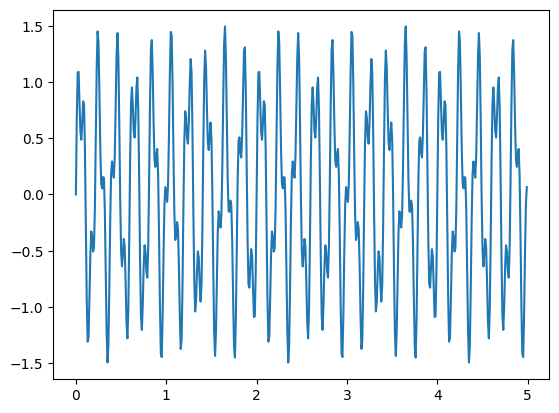

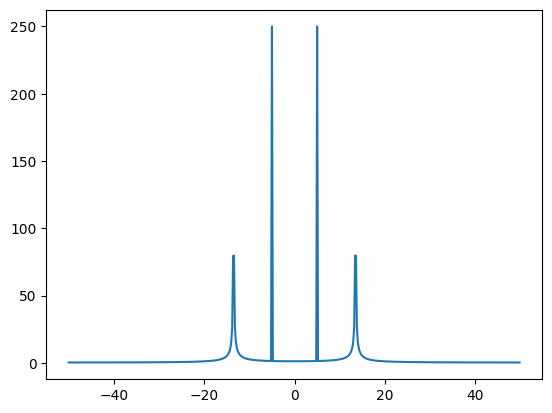

In [42]:
import numpy as np
import matplotlib.pyplot as plt

dt = 1e-2 # [s]
t = np.arange(0, 5, dt) # the time intervals
f = np.sin(5*2*np.pi*t) + .5*np.sin(13.5*2*np.pi*t)

F = np.fft.fft(f) # the Discrete Fourier Transform
freq = np.fft.fftfreq(len(t), d = dt) # the frequencies at which to evaluate the spectrum

F = np.fft.fftshift(F)
freq = np.fft.fftshift(freq)

# We first plot the signal
plt.figure()
plt.plot(t, f)

# then we plot the FFT
plt.figure()
plt.plot(freq, np.absolute(F))

### FFT in 2D

(-5.0, 4.92063492063492, -5.0, 4.92063492063492)

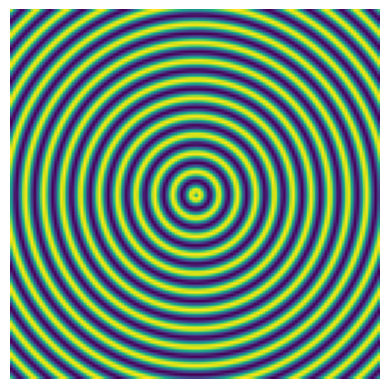

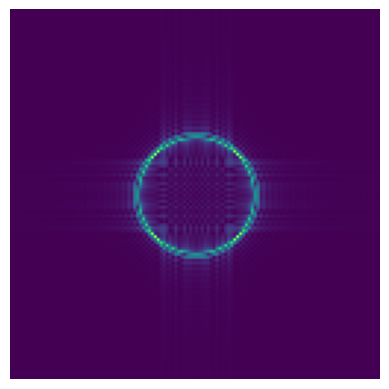

In [48]:
# create a 2D signal
x = np.arange(-2*np.pi, 2*np.pi, 0.1)
y = np.arange(-2*np.pi, 2*np.pi, 0.1)
xx, yy = np.meshgrid(x, y)
#z = np.sin(2*np.pi*1*xx) + np.sin(2*np.pi*2*yy)
z = np.sin(10*np.sqrt(xx**2 + yy**2))

# FFT
Z = np.fft.fft2(z)
Z_shift = np.fft.fftshift(Z)

# shifting the frequencies and imposing the limits
freq_x_shift = np.fft.fftshift(np.fft.fftfreq(len(x), d = 0.1))
freq_y_shift = np.fft.fftshift(np.fft.fftfreq(len(y), d = 0.1))
limits = [freq_x_shift[0], freq_x_shift[-1], freq_y_shift[0], freq_y_shift[-1]]

plt.figure()
plt.imshow(z)
plt.axis('off')

plt.figure()
plt.imshow(np.absolute(Z_shift), extent=limits)
plt.axis('off')

## Artificial Neural Networks (ANN)

In [ ]:
def ANN(x, params, sigma=jnp.tanh, sigma_out=None):
  """
    Compute the output of a neural network  
    params: list of parameters of the network (W1, b1, W2, b2, ...) ORDER MUST BE RESPECTED
    sigma: the activation function to be used, generally jnp.tanh
    sigma_out: the activation function to be used on last layer
    x: input data (N x n1)

    W_i: weight matrix (n_i+1, n_i)
    b_i: bias vector (n_i+1, 1)
  """

  n_layers = int(len(params) / 2 + 1) # number of layers in the network (including the input layer)

  W = params[0::2]  # the weights in the parameters
  b = params[1::2]  # the biases in the parameters

  layer = x.T # input layer, transposed 
 
  # loop over forwarding layers (not consider the input and output one)
  for i in range(n_layers - 1):
    layer = sigma(jnp.dot(W[i], layer) - b[i])
  
  if sigma_out:
    layer = sigma_out(layer)

  return layer.T


### Useful functions

In [ ]:
def get_training_data(N, f, noise, a, b):
  """
    Generate training data for a function f(x)
  """
  np.random.seed(0) # for reproducibility
  x = np.linspace(a, b, N)[:,None]
  y = f(x) + noise * np.random.randn(N,1)
  return x, y


def initialize_params(layers_size):
  """
    Initialize the parameters of the neural network
    layer_size = [n1, n2, n3, ...]  the size of each layer
    
    W_i = random sampling from gaussian
    b_i = zero
  """
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    W = np.random.randn(layers_size[i+1], layers_size[i])
    # W = np.random.randn(layers_size[i+1], layers_size[i]) * np.sqrt(2/(layers_size[i+1] + layers_size[i]))
    b = np.zeros((layers_size[i+1], 1))
    params.append(W)
    params.append(b)
  return params

## Function Plot

It is common practice to rewrite the functions in matrix notation, so to be more efficient when using numpy
$$
    f(x) = 1/2 x^T H x + d^T x + c
$$

In [52]:
def f(x):
    c = 80000
    dt = np.array([4, 4])
    H = np.array([[10, -6], [-6, 10]]) # Hessian matrix
    return  0.5 * jnp.matmul(jnp.matmul(x.T, H), x) + jnp.matmul(dt,x) + c

In [53]:
f_jit = jax.jit(f)
grad_jit = jax.jit(jax.grad(f_jit))

x = np.linspace(-100.0, 100.0, 200)
y = np.linspace(-100.0, 100.0, 200)

points_f = np.array([[f_jit(np.array([i, j])) for i in x] for j in y])
points_grad = np.array([[grad_jit(np.array([i, j])) for i in x] for j in y])
print(points_f.shape)
print(points_grad.shape)


(200, 200)
(200, 200, 2)


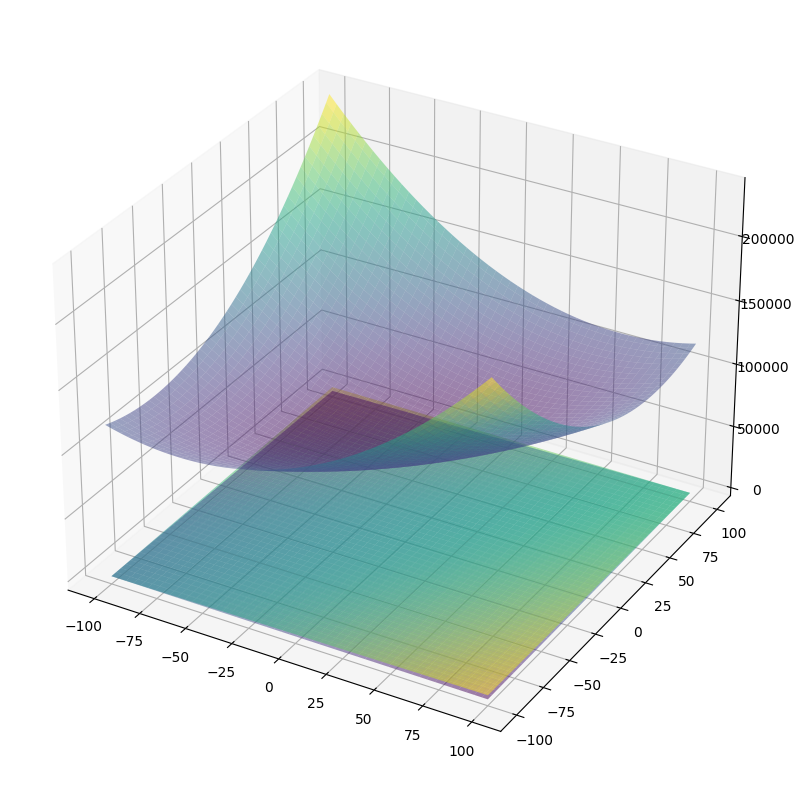

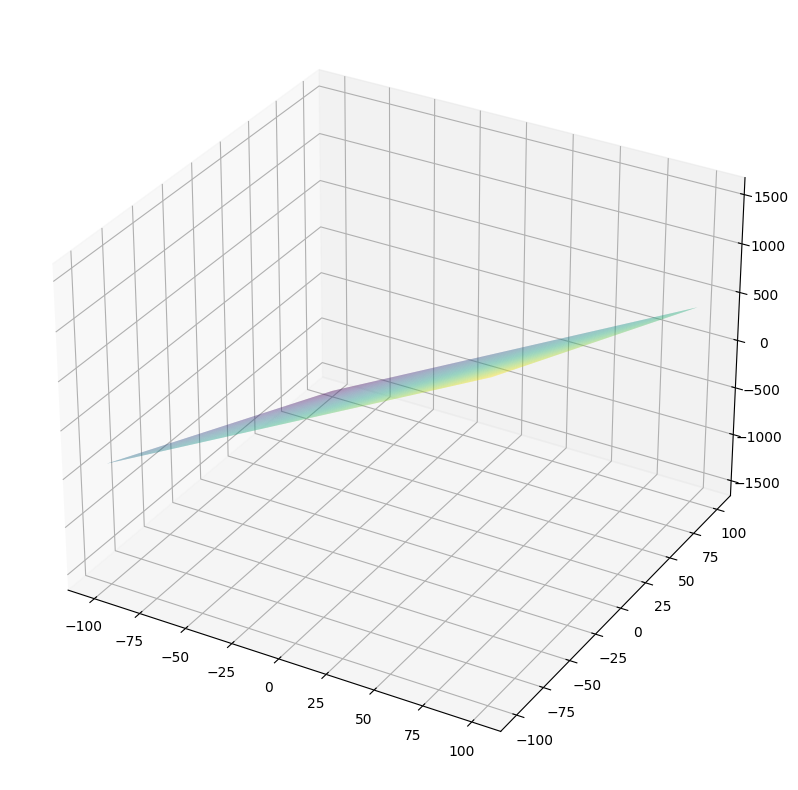

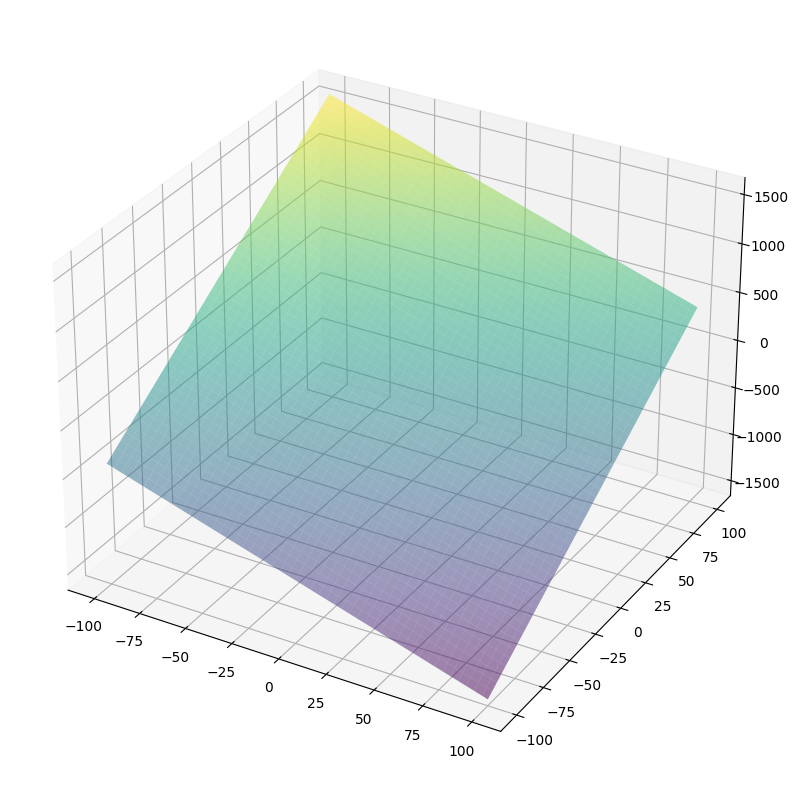

In [54]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(*np.meshgrid(x, y), points_f, cmap = 'viridis', alpha = 0.5)
ax.plot_surface(*np.meshgrid(x, y), points_grad[:, :, 0], cmap = 'viridis', alpha = 0.5)
ax.plot_surface(*np.meshgrid(x, y), points_grad[:, :, 1], cmap = 'viridis', alpha = 0.5)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(*np.meshgrid(x, y), points_grad[:, :, 0], cmap = 'viridis', alpha = 0.5)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(*np.meshgrid(x, y), points_grad[:, :, 1], cmap = 'viridis', alpha = 0.5)

## Gradient Descent

$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given} \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{N} \sum_{i=1}^N \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - \alpha \mathbf{g}^{(k)}
\end{split}
$$

where $\lambda$ is a constant that can be found through linsearch

In [ ]:
########## TO BE DEFINED ##############

x_train = []
y_train = []
params = []

loss_jit = jax.jit() # N.B here the assumption is that the prototype is loss(x, y, params)
grad_jit = jax.jit(jax.grad(loss_jit, argnums=2)) # argnums=2 means that we compute the gradient on 3rd argument

########## PROBLEM DATA ################
learning_rate = 1e-1
num_epochs = 20000
########################################

history = list()

for epoch in range(num_epochs):

  grads = grad_jit(x_train, y_train, params) # computes the gradients of the squ. loss
  for i in range(len(params)):
    params[i] -= learning_rate * grads[i]

  history.append(loss_jit(x_train, y_train, params))

### Alternative more complex definition

In [ ]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
learning_rate = 3e-1
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss_jit, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 500)

# Training loop --> we apply gradient descent to minimize the loss function
for epoch in range(num_epochs):
  grads = grad_jit(xx, yy, params)
  for i in range(len(params)):
    params[i] -= learning_rate * grads[i]
  history.append(loss_jit(xx, yy, params))
  cb(epoch)
cb.draw()

print('loss: %1.3e' % history[-1])

## Stochastic Gradient Descent

Implement the SGD method:
$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given} \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - \lambda_k \mathbf{g}^{(k)}
\end{split}
$$
where $I_k$ is the current minibatch. To select it, use the function [np.random.choice](https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html) with replacement.

Consider a linear decay of the learning rate:
$$
\lambda_k = \max\left(\lambda_{\textnormal{min}}, \lambda_{\textnormal{max}} \left(1 - \frac{k}{K}\right)\right)

In [ ]:
########## TO BE DEFINED ##############

x_train = []
y_train = []
params = []

loss_jit = jax.jit() # N.B here the assumption is that the prototype is loss(x, y, params)
grad_jit = jax.jit(jax.grad(loss_jit, argnums=2)) # argnums=2 means that we compute the gradient on 3rd argument

########## PROBLEM DATA ################
num_epochs = 20000
learning_rate_max = 0.1e-1
learning_rate_min = 2e-2
learning_rate_decay = 10000
batch_size = 10
########################################

history_train = list()
# history_validation = list()
# indices_set = set()

for epoch in range(num_epochs):
  learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay)) # learning rate decay
  idxs = np.random.choice(n_training_points, batch_size)  # calculates the batch indices
  # indices_set.update(idxs)

  grads = grad_jit(x_train[idxs,:], y_train[idxs,:], params)
  for i in range(len(params)):
    params[i] -= learning_rate * grads[i]

  history_train.append(loss_jit(x_train, y_train, params))
  # history_validation.append(loss_jit(x_validation, y_validation, params))



### Alternative more complex definition

In [ ]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
learning_rate_max = 0.1e-1
learning_rate_min = 2e-2
learning_rate_decay = 10000
batch_size = 10
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 250)

indices_set = set()

for epoch in range(num_epochs):
  learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay)) # learning rate decay
  idxs = np.random.choice(n_training_points, batch_size)
  indices_set.update(idxs)

  grads = grad_jit(xx[idxs,:], yy[idxs,:], params)
  for i in range(len(params)):
    params[i] -= learning_rate * grads[i]

  history.append(loss_jit(xx, yy, params))
  cb(epoch)
cb.draw()

print('loss: %1.3e' % history[-1])

## Stochastic Gradient Descent with momentum

Implement the SGD method with momentum:
$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given}, \mathbf{v}^{(0)}=\mathbf{0}  \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \mathbf{v}^{(k+1)} = \alpha \mathbf{v}^{(k)} -  \lambda_k \mathbf{g}^{(k)}\\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} + \mathbf{v}^{(k+1)}
\end{split}
$$

Test different choices of $\alpha$.

In [ ]:
########## TO BE DEFINED ##############

x_train = []
y_train = []
params = []

loss_jit = jax.jit() # N.B here the assumption is that the prototype is loss(x, y, params)
grad_jit = jax.jit(jax.grad(loss_jit, argnums=2)) # argnums=2 means that we compute the gradient on 3rd argument

########## PROBLEM DATA ################
num_epochs = 20000
learning_rate_max = 0.1e-1
learning_rate_min = 2e-2
learning_rate_decay = 10000
batch_size = 10
alpha = 0.2
########################################

history_train = list()
# history_validation = list()
# indices_set = set()

velocity = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
  learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay)) # learning rate decay
  idxs = np.random.choice(n_training_points, batch_size)  # calculates the batch indices
  # indices_set.update(idxs)

  grads = grad_jit(x_train[idxs,:], y_train[idxs,:], params)
  for i in range(len(params)):
    velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
    params[i] -= learning_rate * grads[i]

  history_train.append(loss_jit(x_train, y_train, params))
  # history_validation.append(loss_jit(x_validation, y_validation, params))



### Alternative more complex definition

In [ ]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
learning_rate_max = 1e-1
learning_rate_min = 1e-2
learning_rate_decay = 10000
batch_size = 10
alpha = 0.2
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 250)

velocity = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
  learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))
  idxs = np.random.choice(n_training_points, batch_size)
  grads = grad_jit(xx[idxs,:], yy[idxs,:], params)
  
  for i in range(len(params)):
    velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
    params[i] += velocity[i]

  history.append(loss_jit(xx, yy, params))
  cb(epoch)
cb.draw()

print('loss: %1.3e' % history[-1])

## AdaGrad

Implement the AdaGrad algorithm:
$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given}, \mathbf{r}^{(0)}=\mathbf{0}  \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \mathbf{r}^{(k+1)} = \mathbf{r}^{(k)} + \mathbf{g}^{(k)} \odot \mathbf{g}^{(k)}\\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - 
\frac{\lambda}{\delta + \sqrt{\mathbf{r}^{(k+1)}}} \odot \mathbf{g}^{(k)}
\end{split}
$$
where $\delta = 10^{-7}$ is a small constant.
Notice that the operations in the last line should be intepreted "componentwise".
test different choices of the learning rate $\lambda$.

In [ ]:
########## TO BE DEFINED ##############

x_train = []
y_train = []
params = []

loss_jit = jax.jit() # N.B here the assumption is that the prototype is loss(x, y, params)
grad_jit = jax.jit(jax.grad(loss_jit, argnums=2)) # argnums=2 means that we compute the gradient on 3rd argument

########## PROBLEM DATA ################
num_epochs = 2000
batch_size = 10
learning_rate = 1e-1
delta = 1e-7
########################################

history = list()
history.append(loss_jit(x_train, y_train, params))

cumulated_square_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
  idxs = np.random.choice(n_training_points, batch_size)
  grads = grad_jit(x_train[idxs,:], y_train[idxs,:], params)
  
  for i in range(len(params)):
    cumulated_square_grad[i] += grads[i] * grads[i]
    params[i] -= learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]

  history.append(loss_jit(x_train, y_train, params))

## RMSProp

Implement the RMSProp algorithm:
$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given}, \mathbf{r}^{(0)}=\mathbf{0}  \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \mathbf{r}^{(k+1)} = \rho \mathbf{r}^{(k)} + (1 - \rho)\mathbf{g}^{(k)} \odot \mathbf{g}^{(k)}\\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - 
\frac{\lambda}{\delta + \sqrt{\mathbf{r}^{(k+1)}}} \odot \mathbf{g}^{(k)}
\end{split}
$$
where $\delta = 10^{-7}$ is a small constant.
test different choices of the learning rate $\lambda$ and decay rate $\rho$.

In [ ]:
########## TO BE DEFINED ##############

x_train = []
y_train = []
params = []

loss_jit = jax.jit(loss) # N.B here the assumption is that the prototype is loss(x, y, params)
grad_jit = jax.jit(jax.grad(loss_jit, argnums=2)) # argnums=2 means that we compute the gradient on 3rd argument

########## PROBLEM DATA ################
num_epochs = 2000
batch_size = 10
learning_rate = 1e-1
delta = 1e-7
decay_rate = 0.9
########################################

history = list()
history.append(loss_jit(x_train, y_train, params))

cumulated_square_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
  idxs = np.random.choice(n_training_points, batch_size)
  grads = grad_jit(x_train[idxs,:], y_train[idxs,:], params)
  
  for i in range(len(params)):
    cumulated_square_grad[i] = decay_rate*cumulated_square_grad[i] + (1 - decay_rate) * grads[i] * grads[i]
    params[i] -= learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]

  history.append(loss_jit(x_train, y_train, params))

In [ ]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 4000
batch_size = 50
learning_rate = 1e-3
decay_rate = 0.9
delta = 1e-7
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums = 2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate = 250)

cumulated_square_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
  idxs = np.random.choice(n_training_points, batch_size)
  grads = grad_jit(xx[idxs,:], yy[idxs,:], params)
  
  for i in range(len(params)):
    cumulated_square_grad[i] = decay_rate*cumulated_square_grad[i] + (1 - decay_rate) * grads[i] * grads[i]
    params[i] -= learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]

  history.append(loss_jit(xx, yy, params))
  cb(epoch)
cb.draw()

print('loss: %1.3e' % history[-1])

## Newton Method

$$ 
\theta^{(k+1)} = \theta^{(k)} - H_{wk}^{-1} \cdot G_{wk}
$$

Where 
* $\theta^{k}$ is the parameter we want to optimize
* $ H_{wk}^{-1} $ is the inverse of the hessian $\nabla _{wk} ^2 f(x) $
* $ G_{wk}$ is the gradient $\nabla _{wk} f(x) $

In [ ]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

history = []
for epoch in range(num_epochs):
  l = loss_jit(x)
  history.append(l)
  H = hess_jit(x)
  G = grad_jit(x)
  incr = np.linalg.solve(H, -G)
  x += incr

  print('============ epoch %d' % epoch)
  print('loss: %1.3e' % l)
  print('grad: %1.3e' % np.linalg.norm(G))
  print('incr: %1.3e' % np.linalg.norm(incr))

  if np.linalg.norm(incr) < eps:
    break

## BFGS
The BFGS algorithm is used when the objective function is smooth and its gradient can be computed efficiently. It is particularly effective for solving large-scale optimization problems where computing the exact Hessian matrix is computationally expensive or infeasible.

The BFGS algorithm updates an approximation of the Hessian matrix iteratively, using the difference between successive gradient vectors and parameter vectors. This approximation allows the algorithm to estimate the curvature of the objective function and determine the direction of steepest descent.

$$
B_{k+1} = B_k + \frac{(y_k \cdot y_k^T)}{(y_k^T \cdot s_k)} - \frac{(B_k \cdot s_k \cdot s_k^T \cdot B_k)}{(s_k^T \cdot B_k \cdot s_k)}
$$
where:

* $ B_k $ is the approximation of the inverse Hessian matrix at iteration k
* $ y_k = \nabla f(x_k+1) - \nabla f(x_k) $ is the difference between successive gradient vectors
* $s_k = x_{k+1} - x_k$ is the difference between successive parameter vectors

### L-BFGS is actually the true implementation

$$

B_{k+1}=(I-\rho _{k}s_{k}y_{k}^T) \cdot B_{k} \cdot (I-\rho _{k}y_{k}s_{k}^T)+\rho _{k}s_{k}s_{k}^{\top }
$$

* $ B_k $ is the approximation of the **INVERSE** Hessian matrix at iteration k
* $ \rho _k = \frac{1}{y_k^Ts_k}$ is a number
* $ y_k = \nabla f(x_k+1) - \nabla f(x_k) $ is the difference between successive gradient vectors
* $s_k = x_k+1 - x_k$ is the difference between successive parameter vectors

In [ ]:
######### DATA ############
N = 100
max_epochs = 1000
tol = 1e-8

#### TO BE DEFINED #######
x_guess = np.random.rand(N)*2  # The first guess of the algorithm (usually random)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss_jit))

###########################

### Data initialization ###
I = np.eye(N)
Binv = I
epoch = 0
x = x_guess
grad = grad_jit(x)
###########################

history = [loss_jit(x_guess)]

# stop because of tollerance or epochs
while np.linalg.norm(grad) > tol and epoch < max_epochs:
    epoch += 1
    # search direction
    p = - Binv @ grad
    
    # line search
    line_search = scipy.optimize.line_search(loss_jit, grad_jit, x, p)
    alpha = line_search[0]
    x_new = x + alpha * p

    # computing y and s
    s = x_new - x
    x = x_new
    grad_new = grad_jit(x_new)
    y = grad_new - grad
    grad = grad_new

    # Sherman–Morrison update
    rho = 1.0 / (np.dot(y, s))
    E = I - rho * np.outer(y, s)
    Binv = E.T @ Binv @ E + rho * np.outer(s, s)

    history.append(loss_jit(x))

x_ex = np.ones(N)
err = x - x_ex

print('epochs: %d' % epoch)
print('error: %1.3e' % (np.linalg.norm(err) / np.linalg.norm(x_ex)))
plt.semilogy(history, 'o-')

### Alternative more complex solution

In [1]:
N = 100
max_epochs = 1000
tol = 1e-8

np.random.seed(0)
x_guess = np.random.rand(N)*2 # initialized as random guess

epoch = 0
grad = grad_jit(x_guess)
I = np.eye(N)
Binv = I
x = x_guess
history = [loss_jit(x_guess)]

while np.linalg.norm(grad) > tol and epoch < max_epochs:
    epoch += 1
    # search direction
    p = - Binv @ grad
    
    # line search
    line_search = scipy.optimize.line_search(loss_jit, grad_jit, x, p)
    alpha = line_search[0]
    x_new = x + alpha * p

    # computing y and s
    s = x_new - x
    x = x_new
    grad_new = grad_jit(x_new)
    y = grad_new - grad
    grad = grad_new

    # Sherman–Morrison update
    rho = 1.0 / (np.dot(y, s))
    E = I - rho * np.outer(y, s)
    Binv = E.T @ Binv @ E + rho * np.outer(s, s)

    history.append(loss_jit(x))

x_ex = np.ones(N)
err = x - x_ex

print('epochs: %d' % epoch)
print('error: %1.3e' % (np.linalg.norm(err) / np.linalg.norm(x_ex)))
plt.semilogy(history, 'o-')

NameError: name 'np' is not defined

## Linsearch
A method used to find the value of a parameter in a given direction

In [92]:
import scipy

# returns x_new = x0 + alpha * d
x0 = np.array([0.0, 0.0])
d = np.array([-1, -1])

alpha = scipy.optimize.line_search(f_jit, grad_jit, x0, d)[0] # the first parameter is the one we are interested about, the others are useless

print(grad_jit(x0))
print(alpha)
print(x0 + alpha * d)

[4. 4.]
1.0
[-1. -1.]


## Determine learning rate for convergence

In most cases the learning rate is given by one of the two formulas:

**Lipschitz functions**: $\alpha = \frac{R}{L \sqrt{N}}$ where R comes from $||x^{0} - x^{*}|| \le R$ and L from $||\nabla f(x)|| \le L$


**Smooth functions**: $\alpha = \frac{1}{L} $ where L comes from the definition $f(y) <= f(x) + \nabla f(x)^T (y-x) + \frac{L}{2}  ||y-x||^2$

For quadratic functions, the value of L is given by $L = 2 ||Q||_{spectral}$ where Q comes from $f(x) = x^T Q x + d^t x + c$ (General form of a quadratic function where Q is symmetric)

N.B.
The spectral norm of a matrix is **the singular value of maximum value**
Usually can be computed through the SVD

$ U, s, V^T = SVD(Q)$

$||Q||_{spectral} = \sigma_{0}  = s[0]$


### Testing the conjecture

Assume having a Quadratic function like the one of the previous step (therefore a smooth function) because a positive quadratic can always be approximated by a quadratic approximation.

Consider the following values

$ x^0 = (-5, 7) $ starting point

$\epsilon = 10^{-3} $  tollerance

$N = O(\frac{1}{\epsilon}) $ implies N around 1000 iterations

$ E  = |f(x^{k+1}) - f(x{k})| $


16.492422502470642
16.000000000000004
[-17.875  30.125] [-0.96875  2.03125]
[-6.640625 17.359375] [-0.41015625  1.0898438 ]
[-1.3105469 10.689453 ] [-0.20263672  0.5473633 ]
[1.1032715 7.1032715] [-0.16168213  0.21331787]
[2.0903625 5.0903625] [-0.19615936 -0.00865936]
[2.3915672 3.8915672] [-0.2614832  -0.16773319]
[2.3738713 3.1238713] [-0.33621967 -0.28934467]
[2.217762  2.5927625] [-0.41040313 -0.38696563]
[2.0108547 2.1983547] [-0.4797082  -0.46798944]
[1.7946539 1.8884039] [-0.5425474 -0.536688 ]
[1.5879003 1.6347756] [-0.5986303 -0.5957006]
[1.398202  1.4216394] [-0.6482522  -0.64678735]
[1.2278214 1.2395401] [-0.691946  -0.6912136]
[1.076541  1.0824003] [-0.73031545 -0.72994924]
[0.9430715 0.9460012] [-0.7639574 -0.7637743]
[0.825737   0.82720184] [-0.79342836 -0.7933368 ]
[0.72279453 0.72352695] [-0.81923264 -0.81918687]
[0.63258314 0.6329489 ] [-0.84182   -0.8417971]
[0.5535779 0.5537615] [-0.86158824 -0.8615768 ]
[0.48441517 0.48450673] [-0.87888753 -0.8788818 ]
[0.42388058 

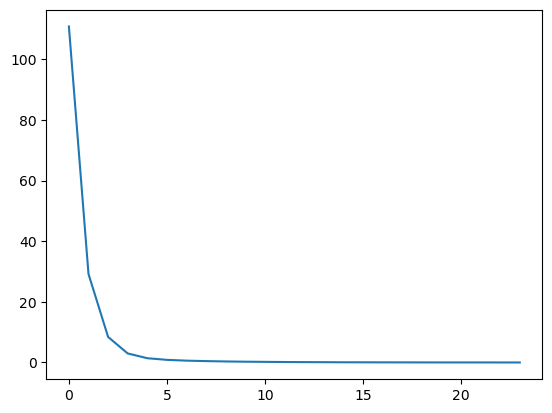

In [130]:
N = 1000
eps = 1e-3
x0 = np.array([-5.0, 7.0])
H = np.array([[10, -6], [-6,10]])


U, s, Vt = np.linalg.svd(H, full_matrices=False)
print(np.linalg.norm(H))
print(s[0])

## Computing L
L = 2 * s[0] # The problem says that the radius of the spectral norm is 1, therefore is 1
alpha = 1/L


f_jit = jax.jit(f)
grad_jit = jax.jit(jax.grad(f_jit))

x_old = x0
x_new = x_old - alpha * grad_jit(x_old)

history_tol = []
while np.abs(f_jit(x_new) - f_jit(x_old)) > eps and len(history_tol) < N:
    x_old = x_new
    x_new = x_old - alpha * grad_jit(x_old)
    print(grad_jit(x_new), x_new)
    history_tol.append(np.abs(f_jit(x_new) - f_jit(x_old)))

plt.plot(history_tol)


## Dual numbers

Dual numbers are numbers that can be represented in this form
$$
    z = a + b \epsilon
$$

Where $\epsilon$ is a nihilpotent quantity for which $\epsilon^2 = 0$

Properties:

* **Addition**: $$ (a + b \epsilon) + (c + d \epsilon) = (a+c) + (b+d)\epsilon$$
* **Multiplication**: $$ (a + b \epsilon) * (c + d \epsilon) = ac + (bc + ad)\epsilon $$
* **Division**: $$ \frac{a + b \epsilon}{c + d \epsilon} = \frac{(a + b \epsilon) * (c + d \epsilon)}{c^2} $$
* **Power**: $$ (a + b \epsilon)^n = a^n + (na^{n-1}b) \epsilon$$
* **Differentiation** $$ f(a + b\epsilon) = f(a) + b f'(a) \epsilon $$

In [1]:
class DualNumber:
  def __init__(self, real, dual):
    # dual number: 'real' + 'dual' * eps
    self.real = real
    self.dual = dual

  def __add__(self, other):
    # implement the operation "self + other"
    if isinstance(other, DualNumber):
      return DualNumber(self.real + other.real,
                        self.dual + other.dual)
    else:
      return DualNumber(self.real + other, self.dual)
  
  def __radd__(self, other):
    # implement the operation "other + self"
    return self.__add__(other)

  def __sub__(self, other):
    # implement the operation "self - other"
    if isinstance(other, DualNumber):
      return DualNumber(self.real - other.real,
                        self.dual - other.dual)
    else:
      return DualNumber(self.real - other, self.dual)

  def __rsub__(self, other):
    # implement the operation "other - self"
    return DualNumber(other, 0.0) - self

  def __mul__(self, other):
    # implement the operation "self * other"
    if isinstance(other, DualNumber):
      return DualNumber(self.real * other.real,
                        self.real * other.dual + self.dual * other.real)
    else:
      return DualNumber(self.real * other, self.dual * other)

  def __rmul__(self, other):
    # implement the operation "other * self"
    return self.__mul__(other)

  def __truediv__(self, other):
    # implement the operation "self / other"
    if isinstance(other, DualNumber):
      return DualNumber(self.real/other.real, (self.dual*other.real - self.real*other.dual)/(other.real**2))
    else:
      return (1/other) * self

  def __rtruediv__(self, other):
    # implement the operation "other / self"
    return DualNumber(other, 0.0).__truediv__(self)

  def __pow__(self, other):
    # implement the operation "self ** other"
    return DualNumber(self.real**other,
                      self.dual * other * self.real**(other - 1))

  def __repr__(self):
    return repr(self.real) + ' + ' + repr(self.dual) + ' epsilon'


## Automatic Differenciation

In [134]:
import jax
import jax.numpy as jnp

def node_up(layer):
    x,y = layer
    return jnp.sin(x + y)
def node_down(layer):
    x,y = layer
    return jnp.cos(x+y)

def computationGraph(x):
    # layer_0 = jnp.array([x, 0])
    # layer_1 = jnp.array([node_up(layer_0), node_down(layer_0)])
    # layer_2 = jnp.array([node_up(layer_1), node_down(layer_1)])
    # layer_3 = jnp.array([node_up(layer_2), node_down(layer_2)])
    layer_3 = jnp.array([x, 0])
    layer_4 = jnp.array([node_up(layer_3), node_down(layer_3)])
    layer_5 = jnp.array([node_up(layer_4), node_down(layer_4)])
    layer_6 = layer_5[0] * layer_5[1]
    return layer_6

f_jit = jax.jit(computationGraph)
grad_jit = jax.jit(jax.grad(computationGraph))

print(grad_jit(1.0))

0.27990246


## Symbolic differentiation

In [3]:
import sympy

x = sympy.symbols('x') # we define a symbol

f_sym = x*sympy.sinh(x**3 + 3*x**4)/(x*sympy.cosh(x**4 + 1))
f_sym_diff = sympy.diff(f_sym, x)

print(f_sym)
print(f_sym_diff)

### evaluating the functions
x0 = 1.45

f0 = f_sym.subs(x, x0)
f0_diff = f_sym_diff.subs(x, x0)

sinh(3*x**4 + x**3)/cosh(x**4 + 1)
-4*x**3*sinh(x**4 + 1)*sinh(3*x**4 + x**3)/cosh(x**4 + 1)**2 + (12*x**3 + 3*x**2)*cosh(3*x**4 + x**3)/cosh(x**4 + 1)


In [14]:
from sympy.matrices import Matrix, ones

x = sympy.symbols('x')
y = sympy.symbols('y')

X = Matrix([x**2, x+y, 2*x])

print("X: ", X)
print("Derivative on x: ", sympy.diff(X, x))
print("Derivative on y: ", sympy.diff(X, y))
print("Matrix operation: ", X.T * X + 2* X.T * ones(3, 1))


X:  Matrix([[x**2], [x + y], [2*x]])
Derivative on x:  Matrix([[2*x], [1], [2]])
Derivative on y:  Matrix([[0], [1], [0]])
Matrix operation:  Matrix([[x**4 + 6*x**2 + 6*x + 2*y + (x + y)**2]])


In [29]:
from sympy.matrices import MatrixSymbol, Matrix

X = MatrixSymbol('X', 2, 1)

x1 = sympy.symbols('x1')
x2 = sympy.symbols('x2')
a1 = sympy.symbols('a1')
a2 = sympy.symbols('a2')
a3 = sympy.symbols('a3')
a4 = sympy.symbols('a4')
b1 = sympy.symbols('b1')
b2 = sympy.symbols('b2')



b = MatrixSymbol('b', 2, 1)
A = MatrixSymbol('A', 2, 2)
c = MatrixSymbol('c', 1, 1)


z = X.T * A * X + b.T * X + c
z_diff = sympy.diff(z, X).subs(X, Matrix([[x1], [x2]])).subs(A, Matrix([[a1, a2], [a3, a4]])).subs(b, Matrix([[b1], [b2]]))


print("Formula: ", z)
print("Derivative: ", sympy.diff(z, X))
print("Evaluation: ", Matrix(z_diff))


Formula:  c + X.T*A*X + b.T*X
Derivative:  A*X + b + A.T*X
Evaluation:  Matrix([[2*a1*x1 + a2*x2 + a3*x2 + b1], [a2*x1 + a3*x1 + 2*a4*x2 + b2]])


Please remember an important result of differentiation

$$
    \frac{\partial (x^T a)}{\partial x} = \frac{\partial (a^T x)}{\partial x} = a
$$

## Singular Value Thresholding (SVT)

This algorithm is extremely useful for matrix completion. The basic idea is to assume a threshold value for the singular values of a matrix, then approximate the matrix to only $ \sigma_i \ge \tau $ then re-imposing the values of the original matrix and iterating the algorithm untill the i. 

In [1]:
import numpy as np
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix

def construct_matrix(rows_known, cols_known, values):
    """
        Constructs the X matrix defined as a sparse matrix whose points are the known directions
           c1 c2 c3 c4 c5  c6     
       r1 |                   |
       r2 |   *            *  |
       r3 |                   |
       r4 | *          *      |
       r5 |   *            *  |

        rows_known: contains the indices of the known rows of the dataset       [r2,  r2,  r4,  r4,  r5,  r5 ]
        cols_known: contains the indices of the known columns of the dataset    [c2,  c6,  c1,  c5,  c2,  c5 ]
        vals:       contains the values that are assigned to each combination   [v22, v26, v41, v45, v52, v55]

    """
    # assumed (N,) and (P,)
    n = rows_known.shape[0]
    p = cols_known.shape[0]

    X_sparse = csr_matrix((values, (rows_known, cols_known)), shape = (n,p))
    X_full = X_sparse.toarray() # the sparse matrix is compressed, we have to expand it

    return X_full



def svt(X, threshold, tollerance, mask_keep, mask_test, n_max_iter= 1000, X_true = None):
    """
         X: input matrix
         threshold: threshold for the singular values
         tollerance: tollerance for the increment
         mask_keep: mask to impose the known values, set it to (rows_train, cols_train) or (rows_known, cols_known)
         mask_test: mask to impose the test values, set it to (rows_test, cols_test) or (rows_unknown, cols_unknown)
         n_max_iter: maximum number of iterations
         X_true: matrix to compare the error (optional) - set it to the X_train matrix 
    """

    A = X.copy() # create a copy of the input matrix that we will modify

    RMSE_list = [] # list to store the RMSE at each iteration
    rho_list = [] # list to store the Pearson correlation at each iteration

    for i in range(n_max_iter):
        A_old = A.copy()
        U,s,VT = np.linalg.svd(A, full_matrices = False)

        # threshold the singular values
        s[s < threshold] = 0
        A = U @ np.diag(s) @ VT # reconstruct the matrix

        A[mask_keep] = X[mask_keep] # impose the known values
        increment = np.linalg.norm(A - A_old) # compute the increment

        ### OPTIONAL - COMPUTE THE ERROR ACCORDING TO THE MATRIX WE WANT TO APPROXIMATE
        if X_true is not None:
            RMSE_list.append(np.sqrt(np.mean((X_true[mask_test]-A[mask_test])**2)))
            rho_list.append(pearsonr(X_true[mask_test].flatten(),A[mask_test].flatten())[0])
            print('=============== Iteration %d - increment norm %1.3e' % (i+1, increment))
            print('RMSE: %1.3f' % RMSE_list[-1])
            print('rho:  %1.3f' % rho_list[-1])
        ################################################################################
        
        # check if the increment is smaller than the tollerance
        if increment < tollerance:
            break


    return A, RMSE_list, rho_list



## Loss Functions
They are the core to evaluate the performance of neural networks

In [49]:
def squared_error(y_label, y_pred):
    return jnp.sum((y_label - y_pred)**2)

def mean_squared_error(y_label, y_pred):
    # y_pred can also be calculated as ANN(params)
    # useful fo regression problems
    return jnp.sqrt(jnp.mean((y_label - y_pred)**2))

def cross_entropy_loss(y_label, y_pred):
    # y_pred can also be calculated as ANN(params)
    # useful for classification problems
    return -jnp.mean(y_label * jnp.log(y_pred) + (1 - y_label) * jnp.log(1 - y_pred))

def mean_absolute_error(y_label, y_pred):
    # y_pred can also be calculated as ANN(params)
    # useful for regression problems and when we want to avoid outliers
    return jnp.mean(jnp.abs(y_label - y_pred))

def hinge_loss(y_label, y_pred):
    # y_pred can also be calculated as ANN(params)
    # useful for classification problems expecially for SVM(perceptron loss)
    t = 2 * y_label - 1  # the function must be transported from {0,1} to {-1,1}
    # when y_pred > 0 and t > 0, the loss will be 0
    # when y_pred < 0 and t < 0, the loss will be 0
    # when y_pred > 0 and t < 0, the loss will be 1 - t * y_pred which is proportional to the distance from the decision boundary
    # when y_pred < 0 and t > 0, the loss will be 1 - t * y_pred
    return jnp.mean(jnp.maximum(0, 1 - t * y_pred)) # the loss is 0 if the prediction is correct, otherwise is 1 - t * y_pred

### Regularization terms

$$
\mathrm{MSW} = \frac{1}{n_{weights}} \sum_{i=1}^{n_{weights}} w_i^2
$$
and define the loss function as
$$
\mathcal{L} = \mathrm{MSE} + \beta \, \mathrm{MSW}
$$
where $\beta$ is a suitable penalization parameter.

In [ ]:
def MSW(params):
  # L2 regularization
  weights = params[::2]
  partial_sum = 0.0
  n_weights = 0
  for W in weights:
    partial_sum += jnp.sum(W*W)
    n_weights += W.shape[0]*W.shape[1]
  return partial_sum / n_weights

## Moore-Penrose pseudo inverse

In [30]:
def moore_penrose_pinv(A):
  U,s,VT = np.linalg.svd(A, full_matrices = False)
  s[s > 0] = 1 / s[s > 0]
  return VT.transpose() @ np.diag(s) @ U.transpose()

## Least Square Regression

### The Least Square problem
arithmetic formulation
$$
    \argmin_{m,q} \sum_{i=1}^N (y_i - (m x_i + q))^2
$$

matrix notation
$$
   \argmin_{\mathbf{w}_{ls}} [(\mathbf{y} - X\mathbf{w})^T(\mathbf{y} - X\mathbf{w})]
$$

### The closed form solution
$$
    \mathbf{\hat{w}_{ls}} = (\Phi ^T \Phi)^{-1} \Phi ^T \mathbf{y}
$$

Using SVD
$$
    \mathbf{\hat{w}_{ls}} = V  (\Sigma ^T \Sigma)^{-1} \Sigma^T U^T \mathbf{y}
$$


In [ ]:
# True parameters
m = 2.0
q = 3.0
N = 100
noise = 2.0
#############

X = np.random.randn(N)
Y = m*X + q + noise * np.random.randn(N)

Phi = np.block([X[:,np.newaxis], np.ones((N,1))])
z = my_pinv2(Phi) @ Y
m_hat = z[0]
q_hat = z[1]
print('m_hat = %f' % m_hat)
print('q_hat = %f' % q_hat)

plt.scatter(X,Y)
plt.plot(X, m*X + q, color = 'red')
plt.plot(X, m_hat*X + q_hat, color = 'green')

## Ridge Regression

### The Ridge Square problem

matrix notation
$$
   \argmin_{\mathbf{w}_{ls}}((\mathbf{y} - X\mathbf{w})^T(\mathbf{y} - X\mathbf{w}) + \lambda ||\mathbf{w}||_2)
$$

### The closed form solution
$$
    \mathbf{\hat{w}} = (\Phi ^T \Phi + \lambda I)^{-1} \Phi ^T \mathbf{y}
$$

or
$$
    \alpha  = (\Phi ^T \Phi + \lambda I)^{-1} \Phi ^T \mathbf{y}
$$
$$
    \mathbf{\hat{w}} = \Phi ^T \mathbf{\alpha}
$$

Finally
$$
    \mathbf{\hat{y}} = \Phi \mathbf{\hat{w}}
$$

In [ ]:
lam = 1.0
PhiPhiT = Phi @ Phi.transpose()
alpha = np.linalg.solve(PhiPhiT + lam*np.eye(N), Y)
w = Phi.transpose() @ alpha
Phi_test = np.block([X_test[:,None], np.ones((N_test,1))])
Y_test_RR = Phi_test @ w

plt.scatter(X,Y, marker = '+', color = 'black', label = 'data')
plt.plot(X_test, Y_test_ex, color = 'black', label = '$y_{ex}(x)$')
plt.plot(X_test, Y_test_LS, color = 'green', label = 'LS regression')
plt.plot(X_test, Y_test_RR, color = 'red', linestyle = '--', label = 'Ridge regression')
plt.legend()

## Kernel Method

The following property can be demonstrated
$$
    \mathbf{\hat{w}} = \Phi^T (K(x_i, x_j) + \lambda I)^{-1} \mathbf{y}
$$
**Train-test example**


Assume we have a dataset
$$
    X = X_{train} + X_{test}
$$
and we can calculate
$$
    y_{train} = f(X_{train})
$$
We can calculate the following
$$
    \alpha = (K_{train} + \lambda I)^{-1} \mathbf{y}
$$
and finally
$$
    y_{test} = \Phi_{test} \mathbf{\hat{w}} = \Phi_{test} \Phi_{train}^T \alpha =  K_{test-train}  \alpha
$$

**kernel regression**. 

1. Scalar product kernel 
$$K(x_i,x_j) = x_i x_j + 1.$$

2. Higher-order scalar product kernel, for $q > 1$.
$$K(x_i,x_j) = (x_i x_j + 1)^q.$$

3. Gaussian kernel, for $\sigma > 0$.
$$K(x_i,x_j) = \exp\left(-\frac{(x_i - x_j)^2}{2 \sigma^2}\right).$$

In [ ]:
def kernel(xi,xj):
    return (xi*xj+1)**6

In [ ]:
lam =  1.0

sigma = 1.0
def kernel(xi,xj):
  return np.exp(-np.abs(xi-xj)**2/(2*sigma**2))

K = np.array([[kernel(X[i],X[j]) for j in range(N)] for i in range(N)])
alpha = np.linalg.solve(K+lam*np.eye(N), Y) # (K + lam*I) * A = y --> A = (K + lam*I)^-1 * y
K_test = np.array([[kernel(X_test[i],X[j]) for j in range(N)] for i in range(N_test)])
Y_test_KR = K_test @ alpha

plt.scatter(X,Y, marker = '+', color = 'black', label = 'data')
plt.plot(X_test, Y_test_ex, color = 'black', label = '$y_{ex}(x)$')
plt.plot(X_test, Y_test_LS, color = 'green', label = 'LS regression')
plt.plot(X_test, Y_test_RR, color = 'red', linestyle = '--', label = 'Ridge regression')
plt.plot(X_test, Y_test_KR, color = 'blue', linestyle = ':', label = 'kernel regression')
plt.legend()
plt.ylim([-2, 2])